#### Definition of the model

* finding the optimal parameters
* finding the optimal equations for mu and qs
* applying **Latin Hypercube Sampling** for generating parameter sets
* calculating the **RMSE** of model and experiment

#### Code

In [2]:
import pandas as pd
import numpy as np
import yaml
from sklearn.metrics import mean_squared_error
from C_model import get_LHS_samples, model_optimization, model_estimation, plot_save, plot_show
from IPython.display import display, Image

In [2]:
# Load experimental data
df_exp = pd.read_csv('data/data_combined.csv')
biomass_exp = df_exp['Biomass [g/L]']
substrate_exp = df_exp['Glucose [g/L]']

In [3]:
# Load parameters from YAML file
with open('config/parameters.yml', 'r') as file:
    param = yaml.safe_load(file)

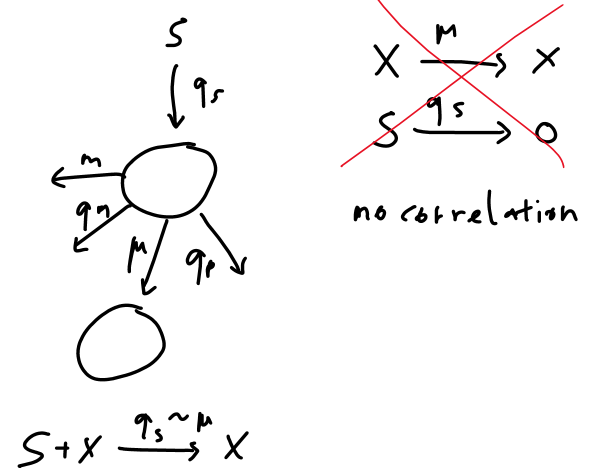

In [4]:
display(Image(filename='images\correlation_muqs.png'))

The growth rate and the substrate uptake rate are dependend on each other. Glucose is present in the media. From there the cell consumes glucose which is described by the glucose uptake rate qs. Many processes are supplied by the energy production due to the glucose such as growth described by the growth rate mu, maintenance, product formation and so on. Consequently, we will find the optimal equation for the glucose uptake and calculate the growth rate mu by $mu = qs * Yxs$.

#### First step: test all qs equations

In [4]:
qs0 = lambda qs_max, c_glucose, Ks: qs_max * c_glucose / (Ks + c_glucose) # -- MONOD
qs1 = lambda qs_max, c_glucose, Ks, Ki, glu_met: qs_max * c_glucose / (Ks + c_glucose) * (Ki / (Ki + glu_met)) # -- MONOD + NON COMPETITIVE INHIBITION
qs2 = lambda qs_max, c_glucose, Ks, c_biomass, lag: qs_max * c_glucose / (Ks + c_glucose) * (1 / (np.exp(c_biomass * lag))) # -- MONOD + METABOLIZED GLU

In [5]:
# Saving all equations in each list
qs_all=[qs0, qs1, qs2]

In [6]:
# Root mean squared error is the objective function
def objective_function(parameters, qs_eq, num_qs):
    # Solve the model using the optimal parameters
    time_pred, biomass_pred, substrate_pred, volume_pred = model_optimization(param, parameters, qs_eq, num_qs)  # Solve the model using the current parameters
    biomass = pd.concat([biomass_exp, pd.Series(biomass_pred)], axis=1, keys=['biomass_exp', 'biomass_pred']).dropna()
    biomass_exp_ = biomass['biomass_exp'].values
    biomass_pred_ = biomass['biomass_pred'].values
    mse_x = mean_squared_error(biomass_exp_, biomass_pred_)  # Calculate mean squared error for biomass

    glucose = pd.concat([substrate_exp, pd.Series(substrate_pred)], axis=1, keys=['substrate_exp', 'substrate_pred']).dropna()
    substrate_exp_ = glucose['substrate_exp'].values
    substrate_pred_ = glucose['substrate_pred'].values
    mse_s = mean_squared_error(substrate_exp_, substrate_pred_)  # Calculate mean squared error for substrate
    
    # Calculate the combined rmse
    mse = (mse_x + mse_s)/2
    rmse = np.sqrt(mse)  # Calculate root mean squared error
    return rmse, time_pred, biomass_pred, substrate_pred, volume_pred

In [7]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 6

# Define the ranges for each parameter
parameter_bounds = [
    [0.3, 0.5],    # Range for parameter 0 Yxs
    [0.5, 1.5],    # Range for parameter 1 qs_max
    [0.0, 1.0],   # Range for parameter 2 - Ks
    [1.0, 11.0],   # Range for parameter 3 - Ki
    [0.0, 0.01],    # Range for parameter 4 - m_s
    [0.001, 1.0],  # Range for parameter 5 - lag
]

In [8]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 6)

In [9]:
df_all_sets = pd.DataFrame(columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])
    for j in range(len(qs_all)):
        qs_eq = qs_all[j]; num_qs = j   

        # Make the predictions and calculate the error
        rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function(init_p, qs_eq, num_qs)
        # save the parameters in a dataframe
        append_list=[set_num, j, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], init_p[5], round(rmse, 3)]
        rmse_one_set.append(append_list)

        # Make a plot and save it
        title = f'set{set_num}/ qs{j} - rmse: {round(rmse, 3)}'
        plot_name = f'set{set_num}_qs{j}_rmse{int(rmse)}'

        if rmse <= float(6):
            plot_save(time_pred, biomass_pred, substrate_pred, volume_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'qs', 'Yxs', 'qs_max', 'Ks', 'Ki', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)


df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/estimation/0207_6/data.csv')

df_all_sets.head(10)

,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
275,91,2,0.387044,1.297114,0.975851,6.178224,0.008545,0.252280,4.695
200,66,2,0.364461,0.832309,0.252020,9.174418,0.007455,0.191119,4.851
65,21,2,0.305908,1.285670,0.806309,3.515892,0.008631,0.263442,4.926
272,90,2,0.319201,1.029140,0.147578,5.534671,0.008757,0.217888,4.947
23,7,2,0.490203,1.199813,0.820289,6.987473,0.005536,0.293808,5.023
155,51,2,0.345646,0.848958,0.279117,5.451861,0.007946,0.243804,5.136
293,97,2,0.471548,1.274646,0.457084,6.761051,0.006787,0.328500,5.206
221,73,2,0.368585,1.241071,0.379546,3.033684,0.007793,0.341265,5.229
206,68,2,0.432546,1.446651,0.752349,10.143109,0.000889,0.201531,5.264
8,2,2,0.392613,0.672052,0.026899,2.017969,0.001042,0.134431,5.298


In [10]:
df_LHS1 = pd.read_csv('data/estimation/0207_1/data.csv')
df_LHS2 = pd.read_csv('data/estimation/0207_2/data.csv')
df_LHS3 = pd.read_csv('data/estimation/0207_3/data.csv')
df_LHS6 = pd.read_csv('data/estimation/0207_6/data.csv')

In [11]:
df_LHS6.head(10)

,Unnamed: 0,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
0,65,21,2,0.429105,1.051743,0.005610,5.758884,0.0,0.216643,4.589
1,200,66,2,0.454154,0.813707,0.044050,12.407756,0.0,0.189858,4.596
2,143,47,2,0.439921,1.336103,0.505112,8.509906,0.0,0.229657,4.714
3,248,82,2,0.355107,1.100784,0.866411,14.955580,0.0,0.238776,4.729
4,35,11,2,0.338099,1.466553,0.956322,1.558971,0.0,0.252646,4.819
5,155,51,2,0.368290,1.241194,0.149050,3.171669,0.0,0.302250,4.903
6,38,12,2,0.363398,1.363592,0.306333,7.354949,0.0,0.339845,5.129
7,176,58,2,0.465780,0.982344,0.713078,9.421669,0.0,0.164783,5.170
8,119,39,2,0.470348,1.005851,0.828391,11.501675,0.0,0.276737,5.174
9,257,85,2,0.380786,1.155516,0.490726,1.882965,0.0,0.315512,5.207


In [12]:
p43 = [0.3438, 0.9786, 0.0035, 8.4651, 0.0330, 0.2240]
p13 = [0.3902, 1.2433, 0.2794, 9.1011, 0.0627, 0.2494]

Best parameter set for qs1

In [19]:
qs_p27 = df_LHS3[df_LHS3['set'] == 27]
qs_p27

,Unnamed: 0,set,qs,Yxs,qs_max,Ks,Ki,m_s,lag,rmse
57,83,27,2,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,7.360
93,82,27,1,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,43.126
94,81,27,0,0.326818,0.520688,0.490661,3.177443,0.221605,0.50004,46.566


In [20]:
p27 = [0.3268, 0.5207, 0.4907, 3.1774, 0.2216, 0.5000]

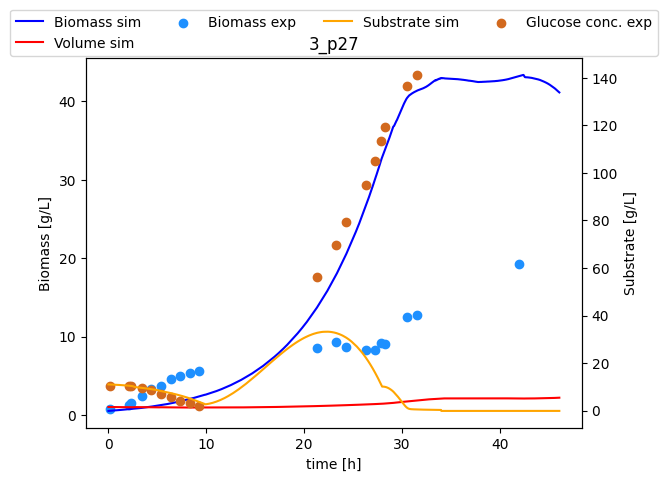

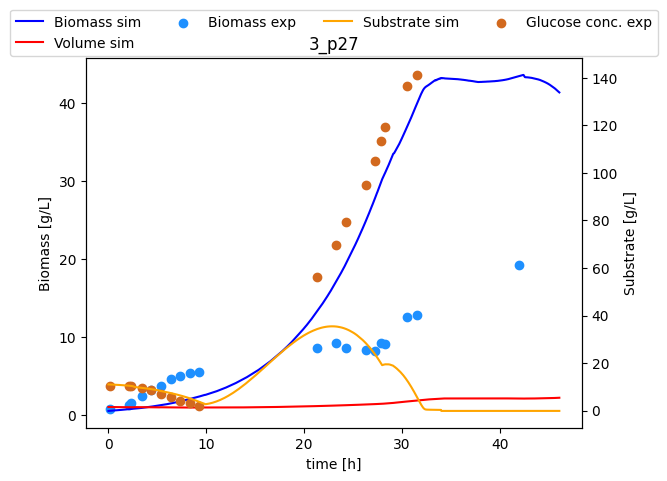

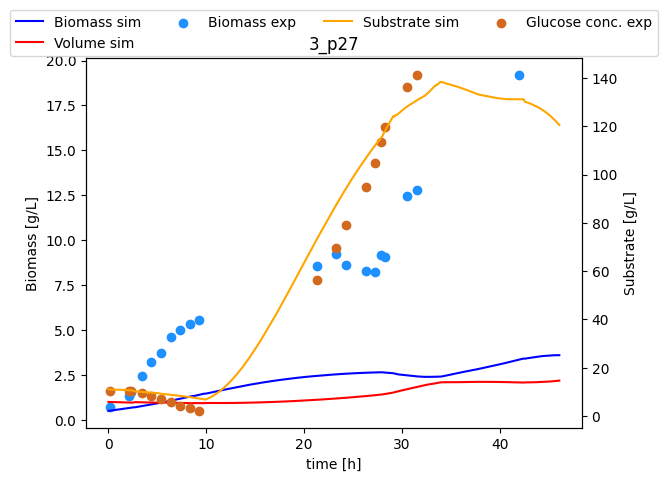

In [22]:
title = '3_p27'
set_num = '3_p27'
for j in range(len(qs_all)):
    qs_eq = qs_all[j]; num_qs = j
    rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_function(p27, qs_eq, num_qs)
    plot_show(time_pred, biomass_pred, substrate_pred, volume_pred, title, set_num)

#### Second step: testing parameters for qs2

In [13]:
def objective_func_qs2(parameters):
    # Solve the model using the optimal parameters
    time_pred, biomass_pred, substrate_pred, volume_pred = model_estimation(param, parameters)  # Solve the model using the current parameters
    biomass = pd.concat([biomass_exp, pd.Series(biomass_pred)], axis=1, keys=['biomass_exp', 'biomass_pred']).dropna()
    biomass_exp_ = biomass['biomass_exp'].values
    biomass_pred_ = biomass['biomass_pred'].values
    mse_x = mean_squared_error(biomass_exp_, biomass_pred_)  # Calculate mean squared error for biomass

    glucose = pd.concat([substrate_exp, pd.Series(substrate_pred)], axis=1, keys=['substrate_exp', 'substrate_pred']).dropna()
    substrate_exp_ = glucose['substrate_exp'].values
    substrate_pred_ = glucose['substrate_pred'].values
    mse_s = mean_squared_error(substrate_exp_, substrate_pred_)  # Calculate mean squared error for substrate
    
    # Calculate the combined rmse
    mse = (mse_x + mse_s)/2
    rmse = np.sqrt(mse)  # Calculate root mean squared error
    return rmse, time_pred, biomass_pred, substrate_pred, volume_pred

In [14]:
# Set the number of samples and parameters
num_samples = 100
num_parameters = 5

# Define the ranges for each parameter
parameter_bounds = [
    [0.3, 0.5],    # Range for parameter 0 Yxs
    [0.5, 1.5],    # Range for parameter 1 qs_max
    [0.0, 1.0],   # Range for parameter 2 - Ks
    [0.0, 0.01],    # Range for parameter 4 - m_s
    [0.001, 1.0],  # Range for parameter 5 - lag
]

In [15]:
LHS_samples = get_LHS_samples(num_samples, num_parameters, parameter_bounds)
LHS_samples.shape

(100, 5)

In [16]:
df_all_sets = pd.DataFrame(columns=['set', 'Yxs', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
for set_num in range(LHS_samples.shape[0]):
    # Save all parameters and equations and the RMSE in a dataframe
    ## with the beginning of one set a new rmse_overview will be created
    rmse_one_set = []
    #key = f'set{set_num}' ; init_p = est_mu_max[key]
    init_p = list(LHS_samples[set_num, :])

    # Make the predictions and calculate the error
    rmse, time_pred, biomass_pred, substrate_pred, volume_pred = objective_func_qs2(init_p)
    # save the parameters in a dataframe
    append_list=[set_num, init_p[0], init_p[1], init_p[2], init_p[3], init_p[4], round(rmse, 3)]
    rmse_one_set.append(append_list)

    # Make a plot and save it
    title = f'set{set_num}/ rmse: {round(rmse, 3)}'
    plot_name = f'set{set_num}_rmse{int(rmse)}'

    if rmse <= float(6):
        plot_save(time_pred, biomass_pred, substrate_pred, volume_pred, title, plot_name, set_num)
        
    # save the parameters of one set
    df_1set = pd.DataFrame(rmse_one_set, columns=['set', 'Yxs', 'qs_max', 'Ks', 'm_s', 'lag', 'rmse'])
    df_all_sets = pd.concat([df_all_sets,df_1set], axis=0, ignore_index=True)


df_all_sets.sort_values(by=['rmse'], ascending=True, inplace=True)
df_all_sets.to_csv(f'data/estimation/data1.csv')

df_all_sets.head(10)

,set,Yxs,qs_max,Ks,m_s,lag,rmse
37,37,0.422992,1.257873,0.924265,0.002875,0.266490,4.704
8,8,0.465192,0.885487,0.814738,0.008927,0.216702,4.705
56,56,0.435231,1.475633,0.237765,0.004016,0.283832,4.789
22,22,0.337037,1.294973,0.697455,0.005820,0.249202,4.813
17,17,0.411362,0.693346,0.278910,0.003726,0.153808,4.953
87,87,0.478441,1.182800,0.405699,0.004708,0.295042,5.005
30,30,0.459651,1.125452,0.681357,0.009363,0.191319,5.035
41,41,0.307342,1.228183,0.543466,0.002221,0.224992,5.056
31,31,0.486899,1.320074,0.539270,0.006227,0.319860,5.131
43,43,0.440506,1.391147,0.798816,0.009055,0.339186,5.150


#### Manual understanding by changing the parameters one by one

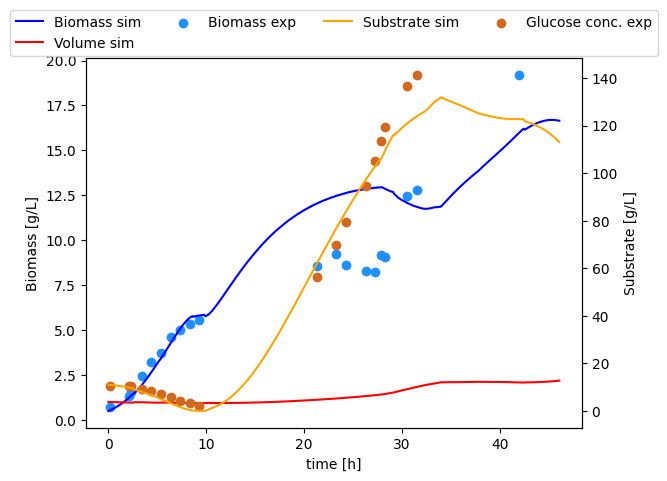

In [7]:
p30 = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, volume_pred = model_estimation(param, p30)
plot_show(time_pred, biomass_pred, substrate_pred, volume_pred)

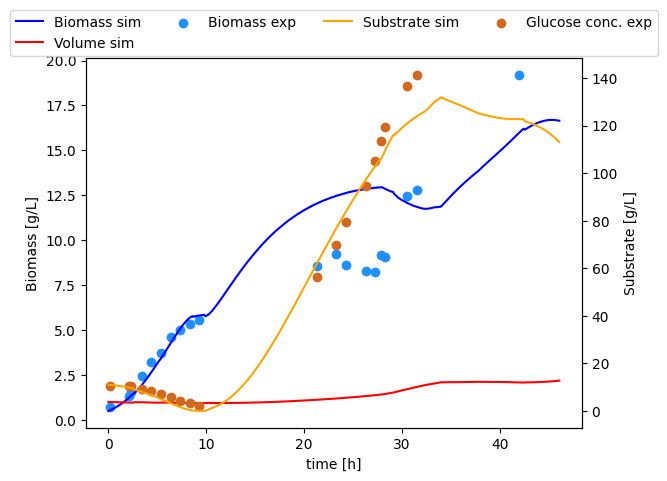

In [36]:
p30 = [0.4597, 1.1255, 0.6814, 0.0094, 0.1913]
time_pred, biomass_pred, substrate_pred, volume_pred = model_estimation(param, p30)
plot_show(time_pred, biomass_pred, substrate_pred, volume_pred)